In [2]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from wmt_data import *
from seq2seq_model import *
from tensorflow.python.framework import ops
from compute_bleu import *

buckets = [(5, 10), (10, 15), (20, 25), (40, 50)]
V_en = 50000; V_fr = 70000; max_train_data_size = 100000
learning_rate = 0.5; num_samples = 512
state_size = 512; num_layers = 3

en_train, fr_train, en_dev, fr_dev, en_vocab_path, fr_vocab_path = prepare_wmt_data(V_en, V_fr)
dev_set = read_data(en_dev, fr_dev, buckets)
train_set = read_data(en_train, fr_train, buckets, max_train_data_size)
vocab_en, rev_vocab_en = initialize_vocabulary(en_vocab_path)
vocab_fr, rev_vocab_fr = initialize_vocabulary(fr_vocab_path)

def create_model():
    ops.reset_default_graph()
    return Seq2SeqModel(V_en, V_fr, buckets, state_size, num_layers, 5.0, learning_rate, num_samples)

  reading data line 100000


In [5]:
import tensorflow as tf, re, time, math, numpy as np
from nltk.translate.bleu_score import sentence_bleu
from wmt_data import *
from compute_bleu import *

# model = create_model()
# saver = tf.train.Saver(tf.all_variables(), max_to_keep=2)

with tf.Session() as sess:
    t = time.time()
    saver.restore(sess, "wmt/my_full_attns.ckpt-300000")
    bleus = computeBleu(sess, model, dev_set, rev_vocab_en, rev_vocab_fr, ppb=2)
    print "Testing takes: ", (time.time()-time_test), "secs. Bleus:", bleus

Restoring model takes:  34.4290161133
Preventing the disease   
Prévention de la maladie 
Prévenir la maladie
------------------
Weight     
_UNK 
Le poids
------------------
A Republican strategy to counter the re-election of _UNK  
Une stratégie de lutte contre le _UNK de _UNK 
Une stratégie républicaine pour contrer la réélection d ' _UNK
------------------
And that ' s not all .    
Et c ' est ce qui n ' est pas le cas . 
Bien plus .
------------------
Republican leaders justified their policy by the need to combat electoral fraud .        
Les dirigeants de la politique ont exprimé leur volonté de se conformer à la nécessité de lutter contre la fraude électorale . 
Les dirigeants _UNK _UNK leur politique par la nécessité de lutter contre la fraude électorale .
------------------
Indeed , Republican lawyers identified only 000 cases of electoral fraud in the United States in a decade .  
En effet , le tribunal a reconnu que 00 cas seulement de fraude de fraude dans les provinces de

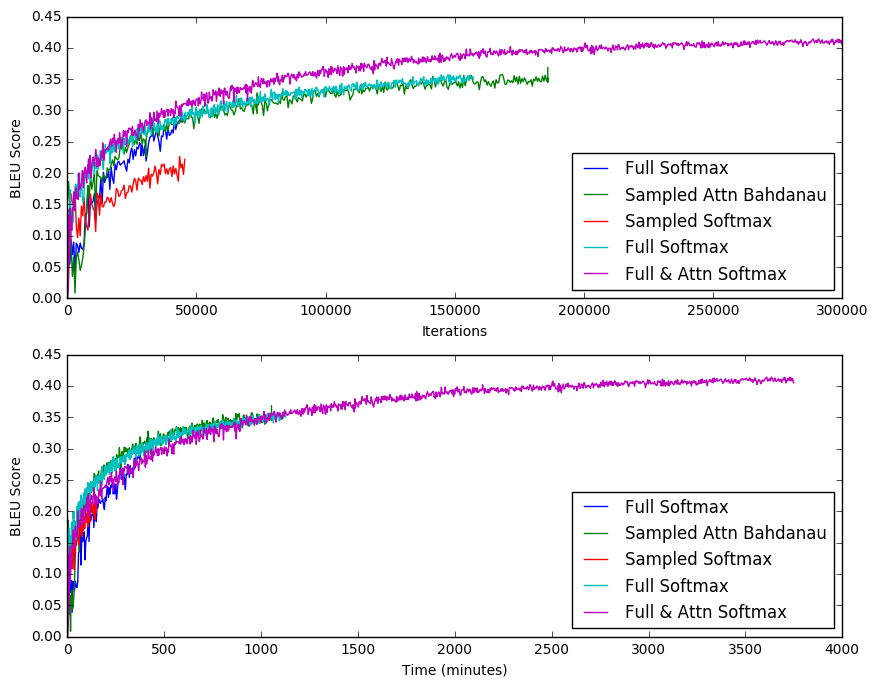

In [58]:
def readSSV(fn):
    f = open(fn)
    keys = []; vals = [];
    for line in iter(f):
        attrs = line.split(' ')
        keys.append(int(attrs[0]))
        vals.append(float(attrs[1]))
    f.close()
    return keys, vals

allPlots = [
    {'file': 'bleus_full.txt', 'title': 'Full Softmax', 'time_per_it': 0.5},
    {'file': 'bleus_attns.txt', 'title': 'Sampled Attn Bahdanau', 'time_per_it': 0.34},
    {'file': 'bleus_sampled.txt', 'title': 'Sampled Softmax', 'time_per_it': 0.2},
    {'file': 'bleus_my_attns.txt', 'title': 'Full Softmax', 'time_per_it': 0.43},
    {'file': 'bleus_my_full_attns.txt', 'title': 'Full & Attn Softmax', 'time_per_it': 0.75},
]


for p in allPlots:
    steps, bleus = readSSV(p['file'])
    times = [float(a*p['time_per_it']/60.0) for a in steps]
    plt.subplot(2, 1, 1)
    plt.plot(steps, bleus, label=p['title'])
    plt.subplot(2, 1, 2)
    plt.plot(times, bleus, label=p['title'])

plt.subplot(2, 1, 1)
plt.legend(loc='lower right'); plt.xlabel("Iterations"); plt.ylabel("BLEU Score")

plt.subplot(2, 1, 2)
plt.legend(loc='lower right'); plt.xlabel("Time (minutes)"); plt.ylabel("BLEU Score")

In [52]:
import tensorflow as tf, re, time, math
from seq2seq_model import *
from wmt_data import *

V_en = 50000; V_fr = 70000;

en_train, fr_train, en_dev, fr_dev, en_vocab_path, fr_vocab_path = prepare_wmt_data(V_en, V_fr)

vocab_en, rev_vocab_en = initialize_vocabulary(en_vocab_path)
vocab_fr, rev_vocab_fr = initialize_vocabulary(fr_vocab_path)

def loadEmbedding(model, checkpoint):
    saver = tf.train.Saver(tf.all_variables(), max_to_keep=2)

    with tf.Session() as sess:
        saver.restore(sess, checkpoint)
        for var in tf.trainable_variables():
            if var.name == 'embedding_attention_seq2seq/RNN/EmbeddingWrapper/embedding:0':
                embedding_op = var
        embedding = sess.run([embedding_op], {})
        emb = np.array(embedding)
        return emb[0]

# embedding is expected to be of shape (V, D)
# embedding = loadEmbedding(model, "wmt/attns.ckpt-186003")
# norm_emb = (embedding ** 2).T / np.sum(embedding ** 2, axis=1) 
# norm_emb = norm_emb.T
norm_emb = embedding
print np.sum(norm_emb)

def analogy(a,b,c, vocab, rev_vocab, n=10):
    # Compute the word that is closer to a-b+c
    # n is the number of candidates you want to keep
    # Example: man-woman + king \simeq queen
    a_i = vocab[a]; b_i = vocab[b]; c_i = vocab[c]
    a_emb = norm_emb[a_i, :]; b_emb = norm_emb[b_i, :]; c_emb = norm_emb[c_i, :]; 
    vec = c_emb + (b_emb - a_emb)
    projs = np.dot(norm_emb, vec) # Dimension V x 1
    good_is = projs.argsort()[-10:][::-1]
    return [rev_vocab[i] for i in good_is]

print analogy('man', 'woman', 'king', vocab_en, rev_vocab_en)
print analogy('old', 'older', 'new', vocab_en, rev_vocab_en)
print analogy('man', 'men', 'woman', vocab_en, rev_vocab_en)
print analogy('bird', 'birds', 'man', vocab_en, rev_vocab_en)

6714.4
['woman', 'king', 'Caribou', 'Agar', 'plus', 'sporadic', 'mischief', 'statistical', 'UPS', 'CIFTA']
['older', 'new', 'waning', 'SUCCESS', 'dispersing', 'outs', 'Cancellation', 'cleanliness', 'Kitchener', 'Attendant']
['woman', 'men', 'ordinances', 'Ethnic', '\xc2\xa8', 'Seller', 'Pedagogical', 'O-Canada', 'STS', 'Kirby']
['man', 'birds', 'Competing', 'undergone', 'Blouin', 'Charles', 'Messages', 'crash', 'gate', 'Backgrounders']
